# Evaluation Demo

This file demonstrates how an evaluation of constrained feature selection could look like.
We use the `Z3` solver for optimization and an own approach for counting the number of valid feature sets.
This means that some lines of code are duplicated and adapted to describe the optimization problem in these two "languages" in parallel.

In [1]:
import matplotlib.pyplot as plt
import random
import z3

import expressions as expr
import solving

## Load Dataset

We use a built-in regression dataset from `scikit-learn`.
We define a feature's quality as the absolute Pearson correlation of that feature with the prediction target.

In [2]:
import pandas as pd
from sklearn.datasets import load_boston

dataset = load_boston()
features = dataset.feature_names
X = pd.DataFrame(dataset.data, columns=features)
y = pd.Series(dataset.target)
print('Dataset shape (without target column):' + str(X.shape))

variables = [expr.Variable() for i in range(len(features))]
z3_variables = z3.Bools(' '.join(['x' + str(i) for i in range(len(features))]))
problem = solving.Problem(variables)
z3_optimizer = z3.Optimize()
feature_qualities = [round(abs(X[x].corr(y)), 2) for x in features] # number representation of Z3 benefits from rounding
z3_objective = z3_optimizer.maximize(z3.Sum([q * s for (q, s) in zip(feature_qualities, z3_variables)]))

Dataset shape (without target column):(506, 13)


## `NAND` Constraints

AND constraints alone are rather boring, as they don't exclude the trivial solution of selecting all features --
they work with the objective, rather than against it.
Thus, we use NAND constraints --
"Don't select all features from a group."

### Generate Constraints

We generate a certain number of constraints involving a certain number of features;
both these experimental parameters are uniformly distributed random numbers.
We repeat the generation a certain number of times.
In each iteration, we solve the optimization problem and store important meta-data,
e.g., the objective value, the number of selected features etc.

In [3]:
# Parameters of generation process
num_repetitions = 100
max_num_constraints = 10
min_num_variables = 2 # within one constraint
max_num_variables = 5 # within one constraint

# Generation
random.seed(25)
results = []
for i in range(num_repetitions):
    z3_optimizer.push() # create checkpoint
    num_constraints = random.randint(1, max_num_constraints)
    for j in range(num_constraints):
        num_variables = random.randint(min_num_variables, max_num_variables)
        selected_variable_idx = random.sample(range(len(features)), k=num_variables)
        selected_variables = [variables[i] for i in selected_variable_idx]
        z3_selected_variables = [z3_variables[i] for i in selected_variable_idx]
        problem.add_constraint(expr.Not(expr.And(selected_variables)))
        z3_optimizer.add(z3.Not(z3.And(z3_selected_variables)))
    z3_optimizer.check()
    frac_solutions = problem.compute_solution_fraction()
    if z3_objective.value().is_int(): # z3 returns different type, depending on whether result is a whole number
        objective_value = z3_objective.value().as_long()
    else:
        objective_value = z3_objective.value().numerator_as_long() / z3_objective.value().denominator_as_long()
    results.append(pd.DataFrame(
        {'num_constraints': [num_constraints],
         'frac_solutions': [problem.compute_solution_fraction()],
         'objective_value': [objective_value],
         'num_selected_features': [sum([str(z3_optimizer.model()[x]) == 'True' for x in z3_variables])]}))
    problem.clear_constraints()
    z3_optimizer.pop() # restore checkpoint
result_table = pd.concat(results)

### Evaluate Constraints

First, we have a look at some summary statistics.

In [4]:
print('Num features: ' + str(len(features)))
print('Unconstrained max objective value: ' + str(sum(feature_qualities)))
result_table.agg(['min', 'mean', 'median', 'max'])

Num features: 13
Unconstrained max objective value: 5.6


,num_constraints,frac_solutions,objective_value,num_selected_features
min,1.00,0.244629,3.9800,9.00
mean,5.66,0.588546,4.7709,10.59
median,6.00,0.578369,4.7900,11.00
max,10.00,0.968750,5.4200,12.00


Next, we create plots.

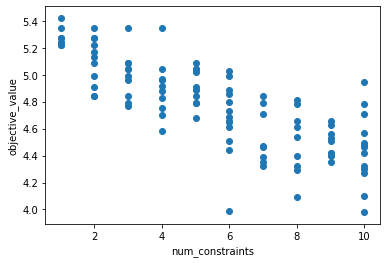

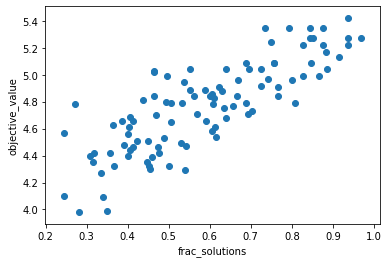

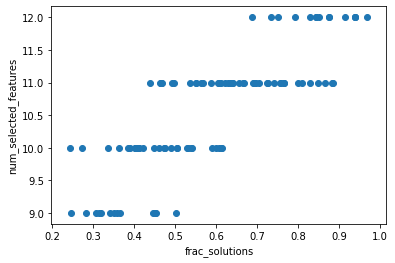

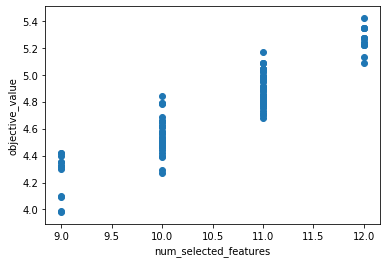

In [5]:
plt.figure()
plt.scatter(x='num_constraints', y='objective_value', data=result_table)
plt.xlabel('num_constraints')
plt.ylabel('objective_value')

plt.figure()
plt.scatter(x='frac_solutions', y='objective_value', data=result_table)
plt.xlabel('frac_solutions')
plt.ylabel('objective_value')

plt.figure()
plt.scatter(x='frac_solutions', y='num_selected_features', data=result_table)
plt.xlabel('frac_solutions')
plt.ylabel('num_selected_features')

plt.figure()
plt.scatter(x='num_selected_features', y='objective_value', data=result_table)
plt.xlabel('num_selected_features')
plt.ylabel('objective_value')

plt.show()

The results are not surprising.
The more we limit the solution space, the lower the objective value becomes.
The limitation of the solution space is directly or indirectly expressed in three quantities:
- number of valid solutions under the constraints (true size of solution space)
- number of constraints (as number of features in constraints varies and constraints might overlap, this is only an approximation for size of solution space)
- number of features (in case of "negative" constraints like NAND, more/stronger constraints tend to favor smaller feature sets)

## `AT_MOST` Constraints

One common constraint -- even in standard feature selection -- is to limit the number of features.
You don't need a solver for that with our objective function -- a greedy approach suffices -- but we evaluate it anyway.

### Generate Constraints

Here, we cut out all randomness.
We simply iterature over all possible sizes of the feature set.

In [6]:
results = []
for num_features in range(1, len(features) + 1):
    z3_optimizer.push() # create checkpoint
    problem.add_constraint(expr.Lt_Eq(expr.Sum(variables), expr.Numeric_Constant(num_features)))
    z3_optimizer.add(z3.AtMost(*z3_variables, num_features))
    z3_optimizer.check()
    frac_solutions = problem.compute_solution_fraction()
    if z3_objective.value().is_int(): # z3 returns different type, depending on whether result is a whole number
        objective_value = z3_objective.value().as_long()
    else:
        objective_value = z3_objective.value().numerator_as_long() / z3_objective.value().denominator_as_long()
    results.append(pd.DataFrame(
        {'frac_solutions': [problem.compute_solution_fraction()],
         'objective_value': [objective_value],
         'num_selected_features': [sum([str(z3_optimizer.model()[x]) == 'True' for x in z3_variables])]}))
    problem.clear_constraints()
    z3_optimizer.pop() # restore checkpoint
result_table = pd.concat(results)

### Evaluate Constraints

First, we have a look at some summary statistics.

In [7]:
print('Num features: ' + str(len(features)))
print('Unconstrained max objective value: ' + str(sum(feature_qualities)))
result_table.agg(['min', 'mean', 'median', 'max'])

Num features: 13
Unconstrained max objective value: 5.6


,frac_solutions,objective_value,num_selected_features
min,0.001709,0.740000,1.0
mean,0.576914,3.547692,7.0
median,0.709473,3.720000,7.0
max,1.000000,5.600000,13.0


Next, we create plots.

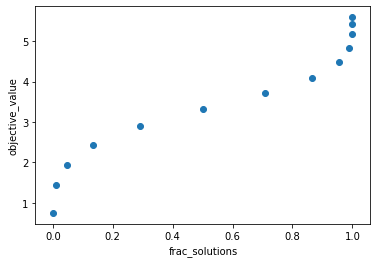

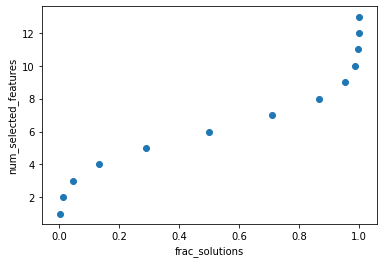

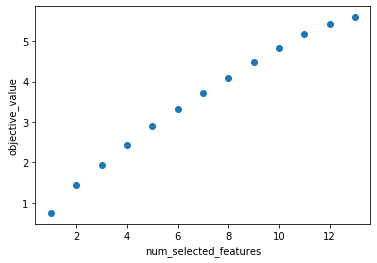

In [8]:
plt.figure()
plt.scatter(x='frac_solutions', y='objective_value', data=result_table)
plt.xlabel('frac_solutions')
plt.ylabel('objective_value')

plt.figure()
plt.scatter(x='frac_solutions', y='num_selected_features', data=result_table)
plt.xlabel('frac_solutions')
plt.ylabel('num_selected_features')

plt.figure()
plt.scatter(x='num_selected_features', y='objective_value', data=result_table)
plt.xlabel('num_selected_features')
plt.ylabel('objective_value')

plt.show()

Again, we see the trade-off between the size of the solution space and the objective value.

## Mixed Constraints

We use an adapted version of the generator in `Materials_Science_Demo.ipynb`, which chooses between several constraint types with a certain probability for each type.

### Generate Constraints

Apart from the more sophisticated constraint generation, the code is the same as for `NAND` constraints.

In [9]:
# Parameters of generation process
num_repetitions = 100
max_num_constraints = 10
min_num_variables = 2 # within one constraint
max_num_variables = 10 # within one constraint

# Generation
random.seed(25)
results = []
for i in range(num_repetitions):
    z3_optimizer.push() # create checkpoint
    num_constraints = random.randint(1, max_num_constraints)
    for j in range(num_constraints):
        constraint_picker = random.random()
        if constraint_picker < 0.4:
            selected_variable_idx = random.sample(range(len(features)), k=2)
            problem.add_constraint(expr.Xor(variables[selected_variable_idx[0]],
                                            variables[selected_variable_idx[1]]))
            z3_optimizer.add(z3.Xor(z3_variables[selected_variable_idx[0]],
                                    z3_variables[selected_variable_idx[1]]))
        else:
            num_variables = random.randint(min_num_variables, max_num_variables)
            selected_variable_idx = random.sample(range(len(features)), k=num_variables)
            selected_variables = [variables[i] for i in selected_variable_idx]
            z3_selected_variables = [z3_variables[i] for i in selected_variable_idx]
            if constraint_picker < 0.55:
                upper_bound = random.randint(1, num_variables)
                problem.add_constraint(expr.Lt_Eq(expr.Sum(selected_variables), expr.Numeric_Constant(upper_bound)))
                z3_optimizer.add(z3.AtMost(*z3_selected_variables, upper_bound))
            elif constraint_picker < 0.7:
                feature_costs = [random.randint(1, 20) for x in selected_variables]
                upper_bound = 10 * num_variables
                problem.add_constraint(expr.Lt_Eq(expr.Weighted_Sum(selected_variables, feature_costs),
                                                  expr.Numeric_Constant(upper_bound)))
                z3_optimizer.add(z3.PbLe(list(zip(z3_selected_variables, feature_costs)), upper_bound))
            elif constraint_picker < 0.85:
                problem.add_constraint(expr.And(selected_variables))
                z3_optimizer.add(z3.And(z3_selected_variables))
            else:
                problem.add_constraint(expr.Or(selected_variables))
                z3_optimizer.add(z3.Or(z3_selected_variables))
    z3_optimizer.check()
    frac_solutions = problem.compute_solution_fraction()
    if z3_objective.value().is_int(): # z3 returns different type, depending on whether result is a whole number
        objective_value = z3_objective.value().as_long()
    else:
        objective_value = z3_objective.value().numerator_as_long() / z3_objective.value().denominator_as_long()
    results.append(pd.DataFrame(
        {'num_constraints': [num_constraints],
         'frac_solutions': [problem.compute_solution_fraction()],
         'objective_value': [objective_value],
         'num_selected_features': [sum([str(z3_optimizer.model()[x]) == 'True' for x in z3_variables])]}))
    problem.clear_constraints()
    z3_optimizer.pop() # restore checkpoint
result_table = pd.concat(results)

### Evaluate Constraints

First, we have a look at some summary statistics.

In [10]:
print('Num features: ' + str(len(features)))
print('Unconstrained max objective value: ' + str(sum(feature_qualities)))
result_table.agg(['min', 'mean', 'median', 'max'])

Num features: 13
Unconstrained max objective value: 5.6


,num_constraints,frac_solutions,objective_value,num_selected_features
min,1.00,0.000000,0.0000,0.00
mean,5.51,0.151008,3.0547,6.92
median,5.00,0.008301,4.3300,10.00
max,10.00,1.000000,5.6000,13.00


Next, we create plots.

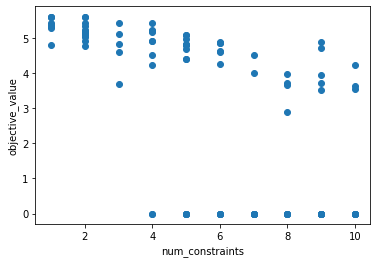

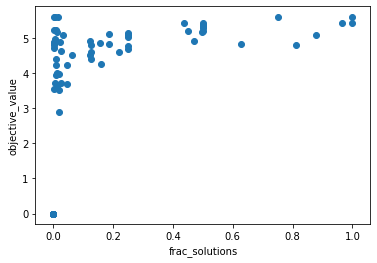

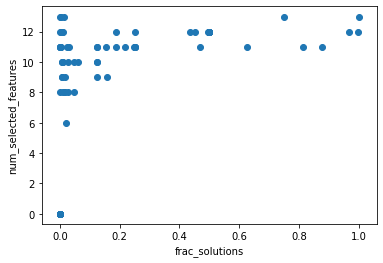

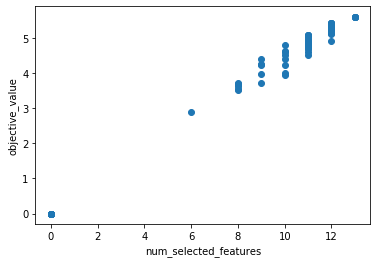

In [11]:
plt.figure()
plt.scatter(x='num_constraints', y='objective_value', data=result_table)
plt.xlabel('num_constraints')
plt.ylabel('objective_value')

plt.figure()
plt.scatter(x='frac_solutions', y='objective_value', data=result_table)
plt.xlabel('frac_solutions')
plt.ylabel('objective_value')

plt.figure()
plt.scatter(x='frac_solutions', y='num_selected_features', data=result_table)
plt.xlabel('frac_solutions')
plt.ylabel('num_selected_features')

plt.figure()
plt.scatter(x='num_selected_features', y='objective_value', data=result_table)
plt.xlabel('num_selected_features')
plt.ylabel('objective_value')

plt.show()

While `NAND` constraints showed a clear relationship between size of solution space and objective value,
the picture is quite unclear for a heterogeneous mix of constraints.
Only the number of features still shows a linear relationship, which is not surprising --
the objective function is linear and non-decreasing in the feature qualities.